## Домашняя работа 4. 

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — кросс-валидация. Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [1]:
import pandas as pd
import numpy as np

In [2]:
data= pd.read_csv('data.adult.csv', sep=',')
data.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
5,18,Private,446771,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25,<=50K
6,31,Federal-gov,108464,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,<=50K
7,18,?,423460,11th,7,Never-married,?,Own-child,White,Male,0,0,36,<=50K
8,25,Private,110138,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,<=50K
9,53,Federal-gov,167410,Bachelors,13,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40,<=50K


In [3]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,16280.000000,1.628000e+04,16280.000000,16280.000000,16280.000000,16280.000000
mean,38.635074,1.894594e+05,10.098219,1020.417752,86.696314,40.403686
std,13.635301,1.066644e+05,2.567690,6862.041550,402.308715,12.341191
min,17.000000,1.930200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.170068e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781340e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.371630e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**(0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [4]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
>50K,<=50K        0
dtype: int64

In [5]:
data[(data == '?').any(axis=1)]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
7,18,?,423460,11th,7,Never-married,?,Own-child,White,Male,0,0,36,<=50K
29,77,?,152900,5th-6th,3,Married-civ-spouse,?,Husband,White,Male,0,0,20,<=50K
36,17,?,89870,10th,6,Never-married,?,Own-child,White,Male,0,0,40,<=50K
38,76,?,431192,7th-8th,4,Widowed,?,Not-in-family,White,Male,0,0,2,<=50K
69,36,?,389850,HS-grad,9,Married-spouse-absent,?,Unmarried,Black,Male,0,0,50,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16188,64,?,196288,Assoc-acdm,12,Never-married,?,Not-in-family,White,Female,0,0,20,<=50K
16223,17,?,202521,11th,7,Never-married,?,Own-child,White,Male,0,0,40,<=50K
16239,19,?,169324,Some-college,10,Never-married,?,Own-child,White,Male,0,0,10,<=50K
16245,59,?,367984,Bachelors,13,Married-civ-spouse,?,Husband,White,Male,0,0,40,<=50K


In [6]:
len(data[(data == '?').any(axis=1)])

933

In [7]:
data = data[~(data == '?').any(axis=1)]
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40,<=50K
16276,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45,>50K
16277,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40,<=50K
16278,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,<=50K


Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [8]:
y = data['>50K,<=50K']
y.head()

0    <=50K
1    <=50K
2    <=50K
3    <=50K
4     >50K
Name: >50K,<=50K, dtype: object

In [9]:
X = data[data.columns[:-1]] 
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40


In [10]:
y.unique()

array(['<=50K', '>50K'], dtype=object)

In [11]:
y = (y == '>50K').astype('int')
y

0        0
1        0
2        0
3        0
4        1
        ..
16275    0
16276    1
16277    0
16278    0
16279    1
Name: >50K,<=50K, Length: 15347, dtype: int32

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15347 entries, 0 to 16279
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15347 non-null  int64 
 1   workclass       15347 non-null  object
 2   fnlwgt          15347 non-null  int64 
 3   education       15347 non-null  object
 4   education-num   15347 non-null  int64 
 5   marital-status  15347 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    15347 non-null  object
 8   race            15347 non-null  object
 9   sex             15347 non-null  object
 10  capital-gain    15347 non-null  int64 
 11  capital-loss    15347 non-null  int64 
 12  hours-per-week  15347 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 1.6+ MB


In [13]:
X_num = X[['age','fnlwgt','education-num', 'capital-gain', 'capital-loss', 'hours-per-week']]
X_num

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
...,...,...,...,...,...,...
16275,25,514716,13,0,0,40
16276,32,207668,13,15024,0,45
16277,27,104457,13,0,0,40
16278,59,268700,9,0,0,40


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - kNN
 - SGD Linear Classifier
 - Naive Bayes Classifier
 - Logistic Regression
 - SVC (Support Vector Classifier)
 
Для начала у первых двух алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе GridSearchCV. В качестве схемы кросс-валидации используйте 5-fold cv.

**(1.5 балла)** Для каждого из первых двух алгоритмов подберите оптимальные значения указанных гиперпараметров. Постройте график среднего качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал (доверительный интервал задается границами [mean - std, mean + std]).

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=0.3, random_state=50)

Вот далее есть один моментик:

Мы на 7 лекции при применении GridSearch использовали Pipeline. В целом мы тут можем обойтись и без него, но ...хоть в задании ничего и не сказано про нормализацию, здравый смысл и ноутбук 7 лекции говорят нам о том, что данные все таки лучше нормировать. 

Поэтому, мы все же используем Pipeline, чтобы в GridSearch закинуть по очереди StandardScaler и Knn :)

А вот сейчас я увидела внизу, что их нужно будет масштабировать (какая я молодец), поэтому пока вычеркнем наш StandartScaler  из Pipeline... :( 

а ниже сделаем с ним!

### KNN

In [16]:
pipe_knn =  Pipeline([
    #('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier()) ])

In [17]:
k_range_knn = list(range(1, 120, 4))
param_grid_knn = dict(knn__n_neighbors=k_range_knn)

In [18]:
grid_knn0 = GridSearchCV(pipe_knn, param_grid_knn, cv=5, scoring='roc_auc', return_train_score=False)
grid_knn0.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 5, 9, 13, 17, 21, 25, 29, 33,
                                              37, 41, 45, 49, 53, 57, 61, 65,
                                              69, 73, 77, 81, 85, 89, 93, 97,
                                              101, 105, 109, 113, 117]},
             scoring='roc_auc')

In [19]:
print(grid_knn0.best_score_)
print(grid_knn0.best_params_)

0.6303244375418531
{'knn__n_neighbors': 5}


Text(0, 0.5, 'Accuracy')

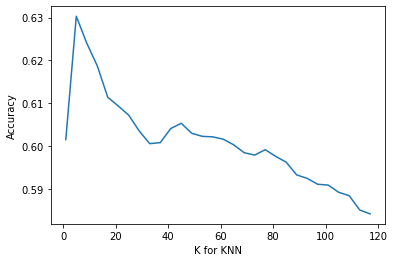

In [20]:
grid_mean_scores_knn0 = grid_knn0.cv_results_['mean_test_score']
plt.plot(k_range_knn, grid_mean_scores_knn0)
plt.xlabel('K for KNN')
plt.ylabel('Accuracy')

In [21]:
grid_std_knn0 = grid_knn0.cv_results_['std_test_score']

Text(0, 0.5, 'Accuracy')

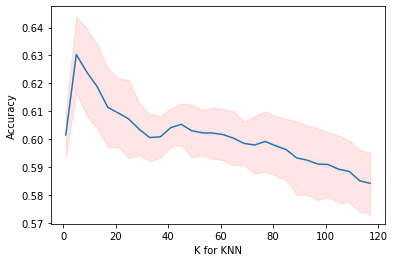

In [22]:
fig, ax = plt.subplots()
ax.plot(k_range_knn, grid_mean_scores_knn0)
ax.fill_between(k_range_knn, (grid_mean_scores_knn0-grid_std_knn0), (grid_mean_scores_knn0+grid_std_knn0), color='red', alpha=.1)
plt.xlabel('K for KNN')
plt.ylabel('Accuracy')

### SGD

Что касается SGD: "SGD Linear Classifier" уже подразумевает, что параметр loss = 'hinge', иначе SGD Classifier будет уже не Linear! Поэтому мы по умолчанию ставим loss = 'hinge', чтобы получить SGD Linear Classifier, как указано в задании, а в качестве гиперапарметра возьмем eta0.

In [23]:
pipe_sgd =  Pipeline([
    #('scaler', StandardScaler()),
    ('sgd', SGDClassifier(loss='hinge',learning_rate='constant', random_state=42))
     ])

In [24]:
k_range_sgd = [ 0.00005, 0.0001, 0.001, 0.1, 5, 10, 50]
param_grid_sgd = dict(sgd__eta0=k_range_sgd)

In [25]:
grid_sgd0 = GridSearchCV(pipe_sgd, param_grid_sgd, cv=5, scoring='roc_auc', return_train_score=False)
grid_sgd0.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sgd',
                                        SGDClassifier(learning_rate='constant',
                                                      random_state=42))]),
             param_grid={'sgd__eta0': [5e-05, 0.0001, 0.001, 0.1, 5, 10, 50]},
             scoring='roc_auc')

In [26]:
print(grid_sgd0.best_score_)
print(grid_sgd0.best_params_)

0.6033310734522541
{'sgd__eta0': 5e-05}


Text(0, 0.5, 'Accuracy')

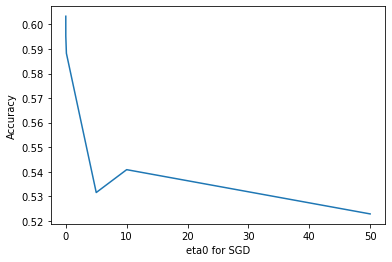

In [27]:
grid_mean_scores_sgd0 = grid_sgd0.cv_results_['mean_test_score']
plt.plot(k_range_sgd, grid_mean_scores_sgd0)
plt.xlabel('eta0 for SGD')
plt.ylabel('Accuracy')

In [28]:
grid_std_sgd0 = grid_sgd0.cv_results_['std_test_score']
grid_std_sgd0

array([0.01879603, 0.02004453, 0.02352284, 0.02096731, 0.02546388,
       0.02340411, 0.01981515])

Text(0, 0.5, 'Accuracy')

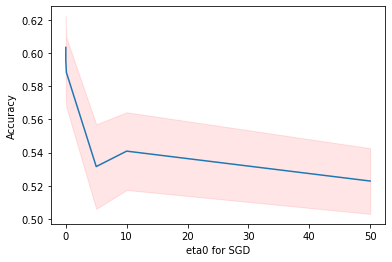

In [29]:
fig, ax = plt.subplots()
ax.plot(k_range_sgd, grid_mean_scores_sgd0)
ax.fill_between(k_range_sgd, (grid_mean_scores_sgd0-grid_std_sgd0), (grid_mean_scores_sgd0+grid_std_sgd0), color='red', alpha=.1)
plt.xlabel('eta0 for SGD')
plt.ylabel('Accuracy')

#### Что вы можете сказать о получившихся графиках?

Что со StandardScaler-ом было лучше:(



**(0.75 балла)** Также подберём параметр регуляризации C в алгоритмах LogisticRegression и SVC.

### LR

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
pipe_lr =  Pipeline([
    #('scaler', StandardScaler()),
    ('lr', LogisticRegression())
     ])

In [32]:
k_range_lr = [0.00001, 0.05, 0.1, 1, 5]
param_grid_lr = dict(lr__C=k_range_lr)

In [33]:
grid_lr0 = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='roc_auc', return_train_score=False)
grid_lr0.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('lr', LogisticRegression())]),
             param_grid={'lr__C': [1e-05, 0.05, 0.1, 1, 5]}, scoring='roc_auc')

In [34]:
print(grid_lr0.best_score_)
print(grid_lr0.best_params_)

0.5877119468490763
{'lr__C': 0.05}


Text(0, 0.5, 'Accuracy')

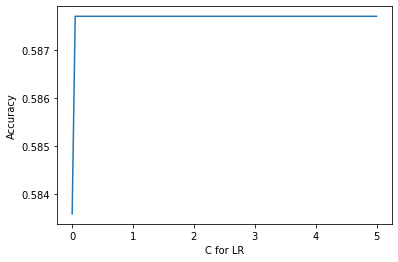

In [35]:
grid_mean_scores_lr0 = grid_lr0.cv_results_['mean_test_score']
plt.plot(k_range_lr, grid_mean_scores_lr0)
plt.xlabel('C for LR')
plt.ylabel('Accuracy')

### SVC

In [36]:
from sklearn.svm import SVC

In [37]:
pipe_svc =  Pipeline([
    #('scaler', StandardScaler()),
    ('svc', SVC())
     ])

In [38]:
k_range_svc = [0.000001, 0.0001, 0.01, 0.05, 0.1, 1]
param_grid_svc = dict(svc__C=k_range_svc)

In [39]:
grid_svc0 = GridSearchCV(pipe_svc, param_grid_svc, cv=5, scoring='roc_auc', return_train_score=False)
grid_svc0.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('svc', SVC())]),
             param_grid={'svc__C': [1e-06, 0.0001, 0.01, 0.05, 0.1, 1]},
             scoring='roc_auc')

In [40]:
print(grid_svc0.best_score_)
print(grid_svc0.best_params_)

0.6318813910924971
{'svc__C': 0.1}


Text(0, 0.5, 'Accuracy')

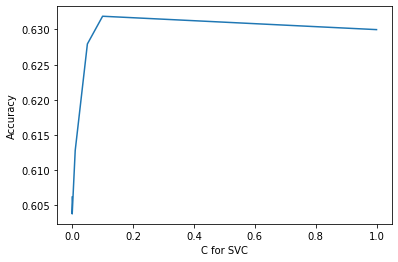

In [41]:
grid_mean_scores_svc0 = grid_svc0.cv_results_['mean_test_score']
plt.plot(k_range_svc, grid_mean_scores_svc0)
plt.xlabel('C for SVC')
plt.ylabel('Accuracy')

**(0.75 балла)** Изучите документацию по алгоритму [Naive Bayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html) и подберите возможные гиперпараметры для этого алгоритма.

### GNB

In [42]:
from sklearn.naive_bayes import GaussianNB

In [43]:
pipe_gnb =  Pipeline([
    #('scaler', StandardScaler()),
    ('gnb', GaussianNB())
     ])

In [44]:
k_range_gnb = np.logspace(0,-10, num=50)
param_grid_gnb = dict(gnb__var_smoothing=k_range_gnb)

In [45]:
grid_gnb0 = GridSearchCV(pipe_gnb, param_grid_gnb, cv=5, scoring='roc_auc', return_train_score=False)
grid_gnb0.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('gnb', GaussianNB())]),
             param_grid={'gnb__var_smoothing': array([1.00000000e+00, 6.25055193e-01, 3.90693994e-01, 2.44205309e-01,
       1.52641797e-01, 9.54095476e-02, 5.96362332e-02, 3.72759372e-02,
       2.32995181e-02, 1.45634848e-02, 9.10298178e-03, 5.68986603e-03,
       3.55648031e-03, 2.22299648e-03, 1.38949549e-03, 8.68511374e-04,
       5.4...
       1.93069773e-06, 1.20679264e-06, 7.54312006e-07, 4.71486636e-07,
       2.94705170e-07, 1.84206997e-07, 1.15139540e-07, 7.19685673e-08,
       4.49843267e-08, 2.81176870e-08, 1.75751062e-08, 1.09854114e-08,
       6.86648845e-09, 4.29193426e-09, 2.68269580e-09, 1.67683294e-09,
       1.04811313e-09, 6.55128557e-10, 4.09491506e-10, 2.55954792e-10,
       1.59985872e-10, 1.00000000e-10])},
             scoring='roc_auc')

In [46]:
print(grid_gnb0.best_score_)
print(grid_gnb0.best_params_)

0.8244433800032759
{'gnb__var_smoothing': 1e-10}


Text(0, 0.5, 'Accuracy')

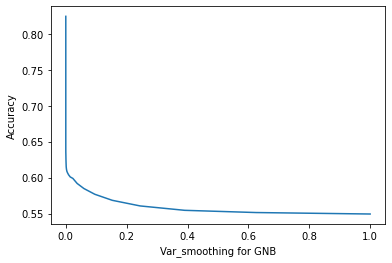

In [47]:
grid_mean_scores_gnb0 = grid_gnb0.cv_results_['mean_test_score']
plt.plot(k_range_gnb, grid_mean_scores_gnb0)
plt.xlabel('Var_smoothing for GNB')
plt.ylabel('Accuracy')

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**(0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

In [48]:
import seaborn as sns

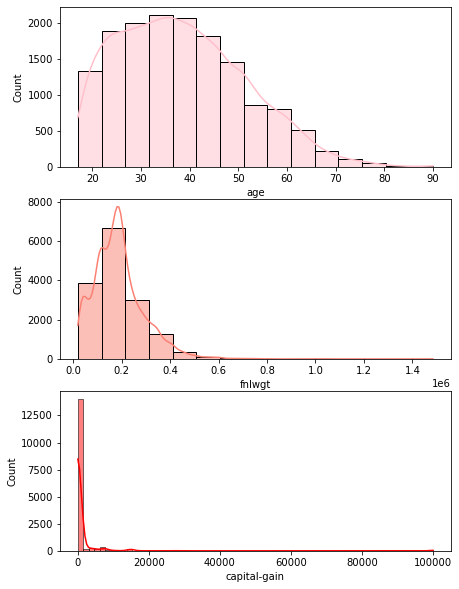

In [49]:
fig, ax = plt.subplots(3, 1, figsize=(7, 10))

sns.histplot(data=X_num, x="age", kde=True, bins = 15 , color = 'pink',  ax=ax[0])
sns.histplot(data=X_num, x="fnlwgt", kde=True,  bins = 15, color = 'salmon' , ax=ax[1])
sns.histplot(data=X_num, x="capital-gain", kde=True, bins = 65, color = 'red' ,ax=ax[2])

plt.show()

У них очень разные шкалы изменения. Именно поэтому мы их сейчас будет масштабировать. Это необходимый шаг, потому что признаки измеряются в разных единицах, а значит покрывают разные диапазоны. Это сильно искажает результаты алгоритмов, например, как метод k-ближайших соседей, которые учитывают расстояния между измерениями. И спойлер: да, на алгоритмы это повлияет!

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**(1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

Ну вот теперь смотрим, как оно было со StandardScaler-ом :)

### KNN

In [50]:
pipe_knn =  Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier()) ])

In [51]:
grid_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=5, scoring='roc_auc', return_train_score=False)
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 5, 9, 13, 17, 21, 25, 29, 33,
                                              37, 41, 45, 49, 53, 57, 61, 65,
                                              69, 73, 77, 81, 85, 89, 93, 97,
                                              101, 105, 109, 113, 117]},
             scoring='roc_auc')

In [52]:
print(grid_knn.best_score_)
print(grid_knn.best_params_)

0.8317510078655387
{'knn__n_neighbors': 81}


In [53]:
grid_mean_scores_knn = grid_knn.cv_results_['mean_test_score']
grid_std_knn = grid_knn.cv_results_['std_test_score']

Text(0, 0.5, 'Accuracy')

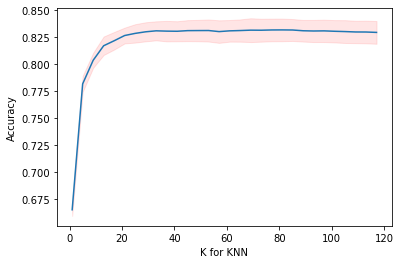

In [54]:
fig, ax = plt.subplots()
ax.plot(k_range_knn, grid_mean_scores_knn)
ax.fill_between(k_range_knn, (grid_mean_scores_knn-grid_std_knn), (grid_mean_scores_knn+grid_std_knn), color='red', alpha=.1)
plt.xlabel('K for KNN')
plt.ylabel('Accuracy')

### SGD

In [55]:
pipe_sgd =  Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier(loss='hinge',learning_rate='constant', random_state=42))
     ])

In [56]:
grid_sgd = GridSearchCV(pipe_sgd, param_grid_sgd, cv=5, scoring='roc_auc', return_train_score=False)
grid_sgd.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sgd',
                                        SGDClassifier(learning_rate='constant',
                                                      random_state=42))]),
             param_grid={'sgd__eta0': [5e-05, 0.0001, 0.001, 0.1, 5, 10, 50]},
             scoring='roc_auc')

In [57]:
print(grid_sgd.best_score_)
print(grid_sgd.best_params_)

0.8210146462182262
{'sgd__eta0': 0.0001}


In [58]:
grid_mean_scores_sgd = grid_sgd.cv_results_['mean_test_score']
grid_std_sgd = grid_sgd.cv_results_['std_test_score']

Text(0, 0.5, 'Accuracy')

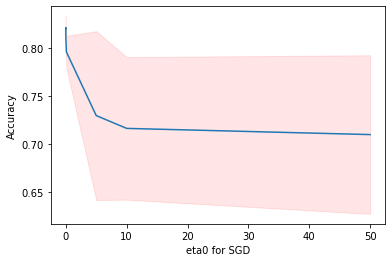

In [59]:
fig, ax = plt.subplots()
ax.plot(k_range_sgd, grid_mean_scores_sgd)
ax.fill_between(k_range_sgd, (grid_mean_scores_sgd-grid_std_sgd), (grid_mean_scores_sgd+grid_std_sgd), color='red', alpha=.1)
plt.xlabel('eta0 for SGD')
plt.ylabel('Accuracy')

### LR

In [60]:
pipe_lr =  Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
     ])

In [61]:
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='roc_auc', return_train_score=False)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [1e-05, 0.05, 0.1, 1, 5]}, scoring='roc_auc')

In [62]:
print(grid_lr.best_score_)
print(grid_lr.best_params_)

0.8251994462491601
{'lr__C': 0.1}


In [63]:
grid_mean_scores_lr = grid_lr.cv_results_['mean_test_score']
grid_std_lr = grid_lr.cv_results_['std_test_score']

Text(0, 0.5, 'Accuracy')

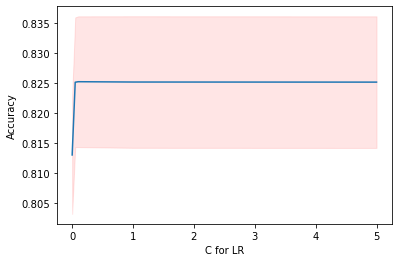

In [64]:
fig, ax = plt.subplots()
ax.plot(k_range_lr, grid_mean_scores_lr)
ax.fill_between(k_range_lr, (grid_mean_scores_lr-grid_std_lr), (grid_mean_scores_lr+grid_std_lr), color='red', alpha=.1)
plt.xlabel('C for LR')
plt.ylabel('Accuracy')

### SVC

In [65]:
pipe_svc =  Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
     ])

In [66]:
grid_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=5, scoring='roc_auc', return_train_score=False)
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [1e-06, 0.0001, 0.01, 0.05, 0.1, 1]},
             scoring='roc_auc')

In [67]:
print(grid_svc.best_score_)
print(grid_svc.best_params_)

0.8182951487321997
{'svc__C': 0.01}


In [68]:
grid_mean_scores_svc = grid_svc.cv_results_['mean_test_score']
grid_std_svc = grid_svc.cv_results_['std_test_score']

Text(0, 0.5, 'Accuracy')

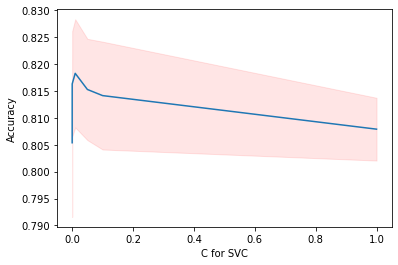

In [69]:
fig, ax = plt.subplots()
ax.plot(k_range_svc, grid_mean_scores_svc)
ax.fill_between(k_range_svc, (grid_mean_scores_svc-grid_std_svc), (grid_mean_scores_svc+grid_std_svc), color='red', alpha=.1)
plt.xlabel('C for SVC')
plt.ylabel('Accuracy')

### GNB

In [70]:
pipe_gnb =  Pipeline([
    ('scaler', StandardScaler()),
    ('gnb', GaussianNB())
     ])

In [71]:
k_range_gnb = np.logspace(0,-10, num=50)
param_grid_gnb = dict(gnb__var_smoothing=k_range_gnb)

In [72]:
grid_gnb = GridSearchCV(pipe_gnb, param_grid_gnb, cv=5, scoring='roc_auc', return_train_score=False)
grid_gnb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gnb', GaussianNB())]),
             param_grid={'gnb__var_smoothing': array([1.00000000e+00, 6.25055193e-01, 3.90693994e-01, 2.44205309e-01,
       1.52641797e-01, 9.54095476e-02, 5.96362332e-02, 3.72759372e-02,
       2.32995181e-02, 1.45634848e-02, 9.10298178e-03, 5.68986603e-03,
       3.55648031e-03, 2.22299648e-03, 1.389...
       1.93069773e-06, 1.20679264e-06, 7.54312006e-07, 4.71486636e-07,
       2.94705170e-07, 1.84206997e-07, 1.15139540e-07, 7.19685673e-08,
       4.49843267e-08, 2.81176870e-08, 1.75751062e-08, 1.09854114e-08,
       6.86648845e-09, 4.29193426e-09, 2.68269580e-09, 1.67683294e-09,
       1.04811313e-09, 6.55128557e-10, 4.09491506e-10, 2.55954792e-10,
       1.59985872e-10, 1.00000000e-10])},
             scoring='roc_auc')

In [73]:
print(grid_gnb.best_score_)
print(grid_gnb.best_params_)

0.8300536949992235
{'gnb__var_smoothing': 0.09540954763499938}


In [74]:
grid_mean_scores_gnb = grid_gnb.cv_results_['mean_test_score']
grid_std_gnb = grid_gnb.cv_results_['std_test_score']

Text(0, 0.5, 'Accuracy')

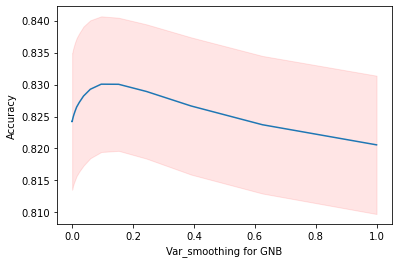

In [75]:
fig, ax = plt.subplots()
ax.plot(k_range_gnb, grid_mean_scores_gnb)
ax.fill_between(k_range_gnb, (grid_mean_scores_gnb-grid_std_gnb), (grid_mean_scores_gnb+grid_std_gnb), color='red', alpha=.1)
plt.xlabel('Var_smoothing for GNB')
plt.ylabel('Accuracy')

Изменилось ли качество у некоторых алгоритмов?

Ну конечно изменилось:)

Давайте сравним!

In [76]:
print('KNN')
print(grid_knn0.best_score_)
print(grid_knn0.best_params_)
print(grid_knn.best_score_)
print(grid_knn.best_params_)
print('..................................')
print('SGD')
print(grid_sgd0.best_score_)
print(grid_sgd0.best_params_)
print(grid_sgd.best_score_)
print(grid_sgd.best_params_)

KNN
0.6303244375418531
{'knn__n_neighbors': 5}
0.8317510078655387
{'knn__n_neighbors': 81}
..................................
SGD
0.6033310734522541
{'sgd__eta0': 5e-05}
0.8210146462182262
{'sgd__eta0': 0.0001}


In [77]:
print('LR')
print(grid_lr0.best_score_)
print(grid_lr0.best_params_)
print(grid_lr.best_score_)
print(grid_lr.best_params_)
print('..................................')
print('SVC')
print(grid_svc0.best_score_)
print(grid_svc0.best_params_)
print(grid_svc.best_score_)
print(grid_svc.best_params_)
print('..................................')
print('GNB')
print(grid_gnb0.best_score_)
print(grid_gnb0.best_params_)
print(grid_gnb.best_score_)
print(grid_gnb.best_params_)

LR
0.5877119468490763
{'lr__C': 0.05}
0.8251994462491601
{'lr__C': 0.1}
..................................
SVC
0.6318813910924971
{'svc__C': 0.1}
0.8182951487321997
{'svc__C': 0.01}
..................................
GNB
0.8244433800032759
{'gnb__var_smoothing': 1e-10}
0.8300536949992235
{'gnb__var_smoothing': 0.09540954763499938}


По результатам видим улучшение во всех моделях!

Единственное только в последней модели GNB мы видим совсем незначительное увеличение точности.

**(1,5 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае, например:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Для оставшихся трех алгоритмов самостоятельно определите, какие наборы гиперпараметров необходимо перебирать и осуществите перебор.

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой.

### KNN

In [78]:
pipe_knn =  Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier()) ])

In [79]:
k_range_knn2_1 = list(range(50, 150, 5))
k_range_knn2_2 = ['euclidean', 'minkowski']

param_grid_knn2 = {
   'knn__n_neighbors': k_range_knn2_1, 
    'knn__metric': k_range_knn2_2}

In [80]:
grid_knn2 = GridSearchCV(pipe_knn, param_grid_knn2, cv=5, scoring='roc_auc', return_train_score=False)
grid_knn2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'minkowski'],
                         'knn__n_neighbors': [50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100, 105, 110, 115, 120,
                                              125, 130, 135, 140, 145]},
             scoring='roc_auc')

In [81]:
print(grid_knn2.best_score_)
print(grid_knn2.best_params_)

0.8316619671587526
{'knn__metric': 'euclidean', 'knn__n_neighbors': 85}


### SGD

In [82]:
pipe_sgd =  Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier(random_state=42))
     ])

In [83]:
#Предупреждалка для проверяющего! 
#The loss ‘log’ was deprecated in v1.1 and will be removed in version 1.3.
#Use loss='log_loss' which is equivalent.
#У меня работает log, но у тедя может сработать не log, а loq_loss! Вот :)

k_range_sgd2_1 = ['hinge','log', 'modified_huber', 'squared_error']
k_range_sgd2_2 = ['l2', 'l1', 'elasticnet']
param_grid_sgd2 = {
   'sgd__loss': k_range_sgd2_1, 
    'sgd__penalty': k_range_sgd2_2}

In [84]:
grid_sgd2 = GridSearchCV(pipe_sgd, param_grid_sgd2, cv=5, scoring='roc_auc', return_train_score=False)
grid_sgd2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sgd',
                                        SGDClassifier(random_state=42))]),
             param_grid={'sgd__loss': ['hinge', 'log', 'modified_huber',
                                       'squared_error'],
                         'sgd__penalty': ['l2', 'l1', 'elasticnet']},
             scoring='roc_auc')

In [85]:
print(grid_sgd2.best_score_)
print(grid_sgd2.best_params_)

0.8221705204302813
{'sgd__loss': 'log', 'sgd__penalty': 'elasticnet'}


### LR

In [86]:
pipe_lr =  Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
     ])

param_grid_lr2 = [
    {'lr__solver':['saga'],'lr__C': [0.00001, 0.05, 0.1, 1, 5],'lr__penalty': ['l1','l2']},
    {'lr__solver':['saga'],'lr__C': [0.00001, 0.05, 0.1, 1, 5],'lr__penalty': ['elasticnet'],
     'lr__l1_ratio': np.linspace(0,1,5)},
    {'lr__solver':['liblinear'],'lr__C': [0.00001, 0.05, 0.1, 1, 5],'lr__penalty': ['l1','l2']}
    ]
    
    
    

In [87]:
grid_lr2 = GridSearchCV(pipe_lr, param_grid_lr2, cv=5, scoring='roc_auc', return_train_score=False)
grid_lr2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             param_grid=[{'lr__C': [1e-05, 0.05, 0.1, 1, 5],
                          'lr__penalty': ['l1', 'l2'], 'lr__solver': ['saga']},
                         {'lr__C': [1e-05, 0.05, 0.1, 1, 5],
                          'lr__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                          'lr__penalty': ['elasticnet'],
                          'lr__solver': ['saga']},
                         {'lr__C': [1e-05, 0.05, 0.1, 1, 5],
                          'lr__penalty': ['l1', 'l2'],
                          'lr__solver': ['liblinear']}],
             scoring='roc_auc')

In [88]:
print(grid_lr2.best_score_)
print(grid_lr2.best_params_)

0.8252107124421105
{'lr__C': 0.1, 'lr__l1_ratio': 0.5, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga'}


### SVC

In [89]:
pipe_svc =  Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
     ])

In [90]:
k_range_svc2_1 = [ 0.0001, 0.01, 0.05, 0.1, 1]
k_range_svc2_2 = ['linear', 'poly', 'rbf']
param_grid_svc2 = {
   'svc__C': k_range_svc2_1,
    'svc__kernel': k_range_svc2_2}

In [91]:
grid_svc2 = GridSearchCV(pipe_svc, param_grid_svc2, cv=5, scoring='roc_auc', return_train_score=False)
grid_svc2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.0001, 0.01, 0.05, 0.1, 1],
                         'svc__kernel': ['linear', 'poly', 'rbf']},
             scoring='roc_auc')

In [92]:
print(grid_svc2.best_score_)
print(grid_svc2.best_params_)

0.8182951487321997
{'svc__C': 0.01, 'svc__kernel': 'rbf'}


В GNB у нас по сути только один гиперпараментр - var_smoothing, и его мы уже сделали выше.

Какой из алгоритмов имеет наилучшее качество?

In [93]:
print('KNN')
print(grid_knn2.best_score_)
print('SGD')
print(grid_sgd2.best_score_)
print('LR')
print(grid_lr2.best_score_)
print('SVC')
print(grid_svc2.best_score_)
print('GNB')
print(grid_gnb.best_score_)

KNN
0.8316619671587526
SGD
0.8221705204302813
LR
0.8252107124421105
SVC
0.8182951487321997
GNB
0.8300536949992235


Получается, что первое место делять между собой KNN и GNB :)

**(0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

In [94]:
import time

### KNN

In [95]:
pipe_knn =  Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier()) ])
param_grid_knn2 = {
   'knn__n_neighbors': [85] , 
    'knn__metric': ['euclidean']}

start = time.time()

grid_knn2 = GridSearchCV(pipe_knn, param_grid_knn2, cv=5, scoring='roc_auc', return_train_score=False)
grid_knn2.fit(X_train, y_train)

end_knn = time.time() - start
print('KNN_time = ',end_knn)

KNN_time =  0.8332791328430176


### SGD

In [96]:
pipe_sgd =  Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier(random_state=42))
     ])
#Напоминалка для проверяющего! 
#The loss ‘log’ was deprecated in v1.1 and will be removed in version 1.3.
#Use loss='log_loss' which is equivalent.
#У меня работает log, но у тедя может сработать не log, а loq_loss!
param_grid_sgd2 = {
   'sgd__loss': ['log'], 
    'sgd__penalty': ['elasticnet']}

start = time.time()

grid_sgd2 = GridSearchCV(pipe_sgd, param_grid_sgd2, cv=5, scoring='roc_auc', return_train_score=False)
grid_sgd2.fit(X_train, y_train)

end_sgd = time.time() - start
print('SGD_time = ',end_sgd)

SGD_time =  0.20894789695739746


### LR

In [97]:
pipe_lr =  Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
     ])
param_grid_lr2 = [
    {'lr__solver':['saga'],'lr__C': [0.1],'lr__penalty': ['elasticnet'],'lr__l1_ratio': [0.5]}]
    
start = time.time()

grid_lr2 = GridSearchCV(pipe_lr, param_grid_lr2, cv=5, scoring='roc_auc', return_train_score=False)
grid_lr2.fit(X_train, y_train)

end_lr = time.time() - start
print('LR_time = ',end_lr)

LR_time =  0.13529014587402344


### SVC

In [98]:
pipe_svc =  Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
     ])
param_grid_svc2 = {
   'svc__C': [0.01],
    'svc__kernel': ['rbf']}

start = time.time()

grid_svc2 = GridSearchCV(pipe_svc, param_grid_svc2, cv=5, scoring='roc_auc', return_train_score=False)
grid_svc2.fit(X_train, y_train)

end_svc = time.time() - start
print('SVC_time = ',end_svc)

SVC_time =  16.84752130508423


### GNB

In [99]:
pipe_gnb =  Pipeline([
    ('scaler', StandardScaler()),
    ('gnb', GaussianNB())
     ])
param_grid_gnb = {'gnb__var_smoothing' : [0.09540954763499938]}

start = time.time()

grid_gnb = GridSearchCV(pipe_gnb, param_grid_gnb, cv=5, scoring='roc_auc', return_train_score=False)
grid_gnb.fit(X_train, y_train)

end_gnb = time.time() - start
print('GNB_time = ',end_gnb)

GNB_time =  0.05920243263244629


Сравним

In [100]:
print('KNN_time = ',end_knn)
print('SGD_time = ',end_sgd)
print('LR_time = ',end_lr)
print('SVC_time = ',end_svc)
print('GNB_time = ',end_gnb)

KNN_time =  0.8332791328430176
SGD_time =  0.20894789695739746
LR_time =  0.13529014587402344
SVC_time =  16.84752130508423
GNB_time =  0.05920243263244629


По времени лучше всего себя показывает Naive Bayes Classifier. А учитывая, что у него и качество одно из лучших...В общем, он the best!

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**(0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [101]:
X1= pd.get_dummies(X, drop_first = True)
X1

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,34,284843,9,594,0,60,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,40,190290,10,0,0,40,0,1,0,0,...,1,0,0,0,0,0,0,0,1,1
2,36,177858,13,0,0,40,1,0,0,0,...,0,0,1,0,0,0,0,0,1,1
3,22,184756,10,0,0,30,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,47,149700,13,15024,0,40,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,514716,13,0,0,40,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
16276,32,207668,13,15024,0,45,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
16277,27,104457,13,0,0,40,0,1,0,0,...,1,0,0,0,0,1,0,0,0,1
16278,59,268700,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


Так как после кодирования признаков получилось достаточно много, в этой работе мы не будем добавлять их и подбирать заново оптимальные гиперпараметры. 

**(0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [102]:
from sklearn.model_selection import cross_val_score

In [103]:
num = X1[['age', 'fnlwgt','education-num', 'capital-gain', 'capital-loss', 'hours-per-week']]  
num_f= num.columns

scaler = StandardScaler()
X1_scaled  = scaler.fit_transform(X1[num_f])
encod_train = X1[list(X1.columns[6:])]
proc_train = np.concatenate([X1_scaled, encod_train], axis=1)

### KNN

In [169]:
KNN = KNeighborsClassifier(n_neighbors=85, metric='euclidean')
scores_knn = cross_val_score(KNN, proc_train , y, scoring='roc_auc', cv=5)
scores_knn.mean()

0.8915081698479213

### SGD

In [170]:
SGD = SGDClassifier(loss = 'log', penalty = 'elasticnet', random_state=42)
scores_sgd = cross_val_score(SGD, proc_train , y, scoring='roc_auc', cv=5)
scores_sgd.mean()

0.9017469609369986

### LR

In [171]:
LR = LogisticRegression(solver='saga', C= 0.1, penalty='elasticnet', l1_ratio= 0.5)
scores_lr = cross_val_score(LR, proc_train , y, scoring='roc_auc', cv=5)
scores_lr.mean()

0.9031379060094199

### SVC

In [172]:
svc_m = SVC(C=0.01,kernel='rbf')
scores_svc = cross_val_score(svc_m, proc_train, y, scoring='roc_auc', cv=5)
scores_svc.mean()

0.8859692614007735

### GNB

In [173]:
GNB = GaussianNB(var_smoothing=0.09540954763499938)
scores_gnb = cross_val_score(GNB, proc_train, y, scoring='roc_auc', cv=5)
scores_gnb.mean()

0.8932367682922105

Да, качество улучшилось в основном.

Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?
Да, отличается, теперь лучшие результаты у LR и SGD.

## Смешивание моделей

Во всех предыдущих пунктах мы получили много хороших моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и логистическая регрессия). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее качество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**(1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

Я так понимаю, что у нас тут возникает проблема, ведь X содержит и категориальные и вещественные прееменные, а значит Pipline, который был у нас ранее будет скалировать категориальные фичи, что плохо. При этом, мы убедились, что скалирование необходимо... Попробуем сделать двумя Pipline-ами отдельно для категориальных и вещетсвенных фичей....

In [178]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn .metrics import roc_auc_score

In [179]:
clf1 = LogisticRegression(solver='saga', C= 0.1, penalty='elasticnet', l1_ratio= 0.5)
clf2 = SGDClassifier(loss = 'log', penalty = 'elasticnet', random_state=42)

In [180]:
for alpha in np.linspace(0,1,10):
    new_clf = VotingClassifier(estimators=[('LR', clf1), ('SGD', clf2)], voting='soft', weights=[alpha,1-alpha])
    print('alpha= ', alpha, '   ', 'roc_auc=', cross_val_score(new_clf, proc_train, y, scoring='roc_auc', cv=5).mean())

alpha=  0.0     roc_auc= 0.9017469609369986
alpha=  0.1111111111111111     roc_auc= 0.902161646255481
alpha=  0.2222222222222222     roc_auc= 0.9025015215187107
alpha=  0.3333333333333333     roc_auc= 0.9027764315709723
alpha=  0.4444444444444444     roc_auc= 0.9029968240021187
alpha=  0.5555555555555556     roc_auc= 0.9031758333653409
alpha=  0.6666666666666666     roc_auc= 0.9032894250256746
alpha=  0.7777777777777777     roc_auc= 0.9033169077660969
alpha=  0.8888888888888888     roc_auc= 0.9032706269119721
alpha=  1.0     roc_auc= 0.9031375724429083


Получается, что лучшая alpha  при смешанной модели LR + SGD находится вблизи 0.777!

Прирост по качеству очевиден :)

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**(1 балл)** Для каждого типа классификатора (kNN, SGD classifier и т.д.), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [181]:
new_clf = VotingClassifier(estimators=[('LR', clf1), ('SGD', clf2)], voting='soft', weights=[0.77, 0.23])
scores_lrsgd = cross_val_score(new_clf, proc_train, y, scoring='roc_auc', cv=5)

In [182]:
all_scores = pd.DataFrame({'knn':scores_knn, 
                   'sgd':scores_sgd,
                   'lr' :scores_lr, 
                   'svc':scores_svc,
                   'gnb':scores_gnb,
                   'scores_lrsgd':scores_lrsgd})

<AxesSubplot:>

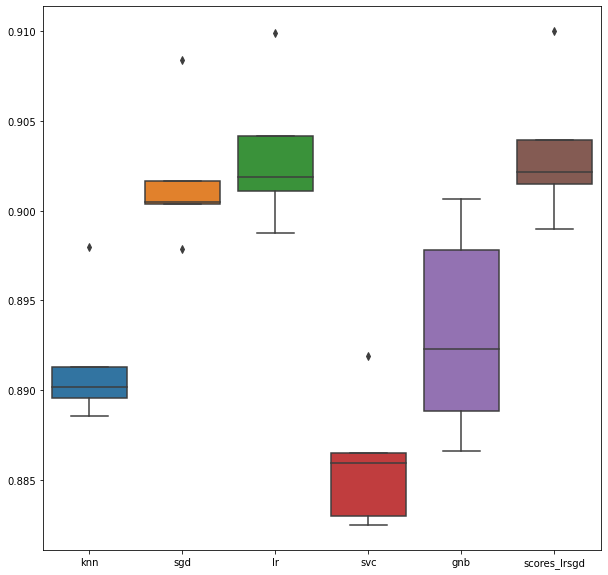

In [183]:
plt.figure(figsize=(10,10))
sns.boxplot(data = all_scores)

Классная домашка!